# 数据处理

数据按`02特征工程`处理，此处不在赘述

## 导入数据

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [3]:
train_data_file = "./data/zhengqi_train.txt"
test_data_file =  "./data/zhengqi_test.txt"

train_data = pd.read_csv(train_data_file, sep='\t', encoding='utf-8')
test_data = pd.read_csv(test_data_file, sep='\t', encoding='utf-8')

## 异常值分析

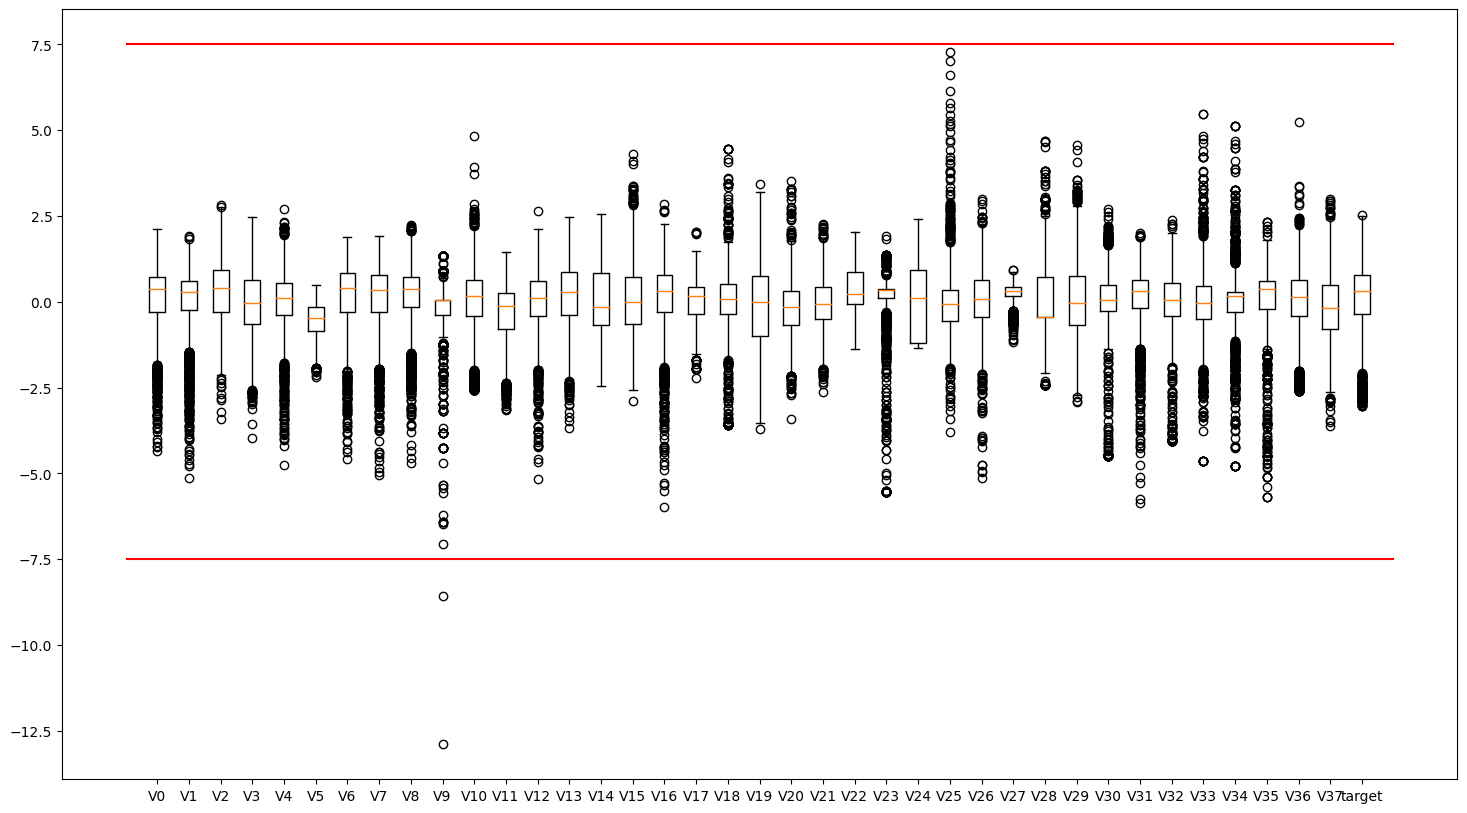

In [4]:
plt.figure(figsize=(18, 10))
plt.boxplot(x=train_data.values,labels=train_data.columns)
plt.hlines([-7.5, 7.5], 0, 40, colors='r')
plt.show()

## 删除异常值

In [5]:
train_data = train_data[train_data['V9']>-7.5]
# print(train_data.describe())
# print(test_data.describe())

## 归一化

In [6]:
from sklearn import preprocessing 

features_columns = [col for col in train_data.columns if col not in ['target']]

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler = min_max_scaler.fit(train_data[features_columns])

train_data_scaler = min_max_scaler.transform(train_data[features_columns])
test_data_scaler = min_max_scaler.transform(test_data[features_columns])

train_data_scaler = pd.DataFrame(train_data_scaler)
train_data_scaler.columns = features_columns

test_data_scaler = pd.DataFrame(test_data_scaler)
test_data_scaler.columns = features_columns

train_data_scaler['target'] = train_data['target']

## 查看数据分布情况

查看特征'V5', 'V17', 'V28', 'V22', 'V11', 'V9'数据的数据分布

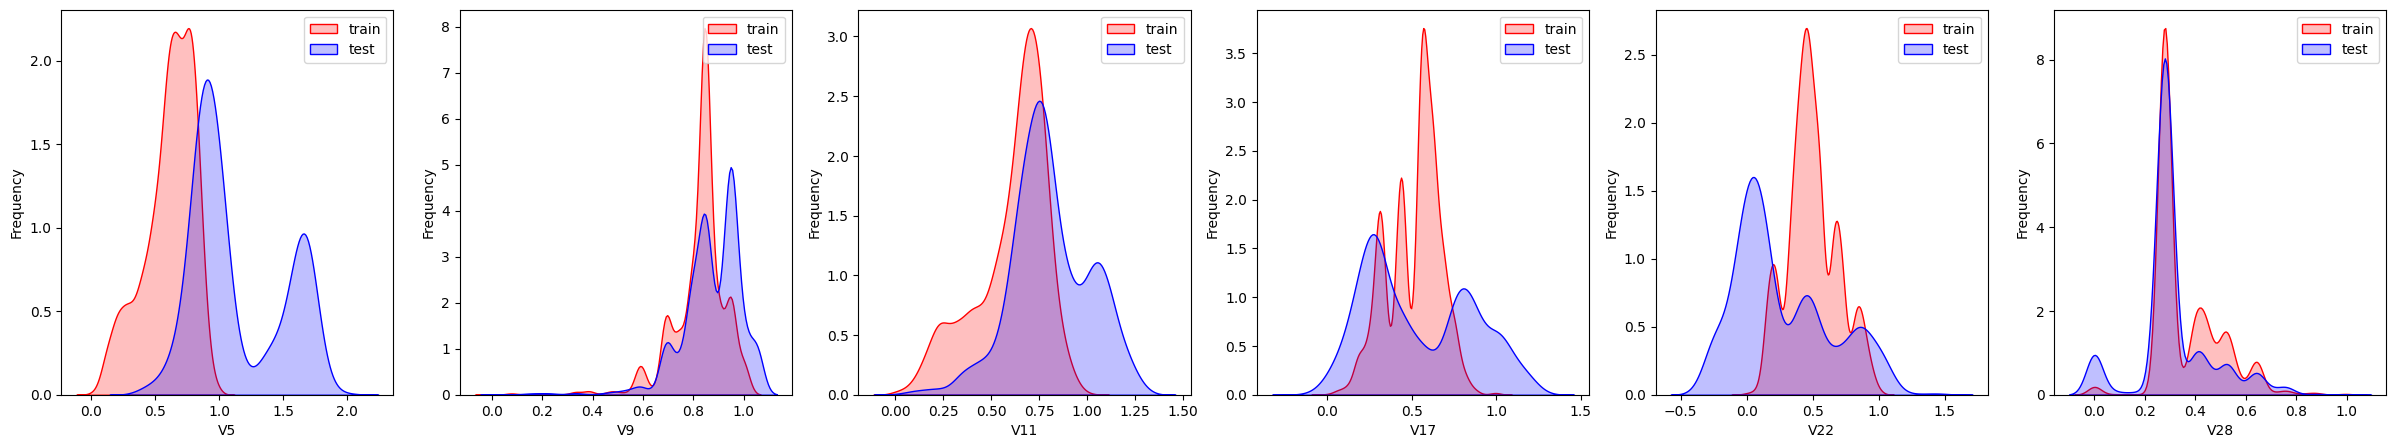

In [7]:
drop_col = 6
drop_row = 1

plt.figure(figsize=(5*drop_col,5*drop_row))

for i, col in enumerate(["V5","V9","V11","V17","V22","V28"]):
    ax =plt.subplot(drop_row,drop_col,i+1)
    ax = sns.kdeplot(train_data_scaler[col], color="Red", shade=True)
    ax= sns.kdeplot(test_data_scaler[col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train","test"])
plt.show()

data_train_scaler = train_data_scaler.drop(['V5','V9','V11','V17','V22','V28'],axis=1)

这几个特征下，训练集的数据和测试集的数据分布不一致，会影响模型的泛化能力，故删除这些特征

## 特征相关性

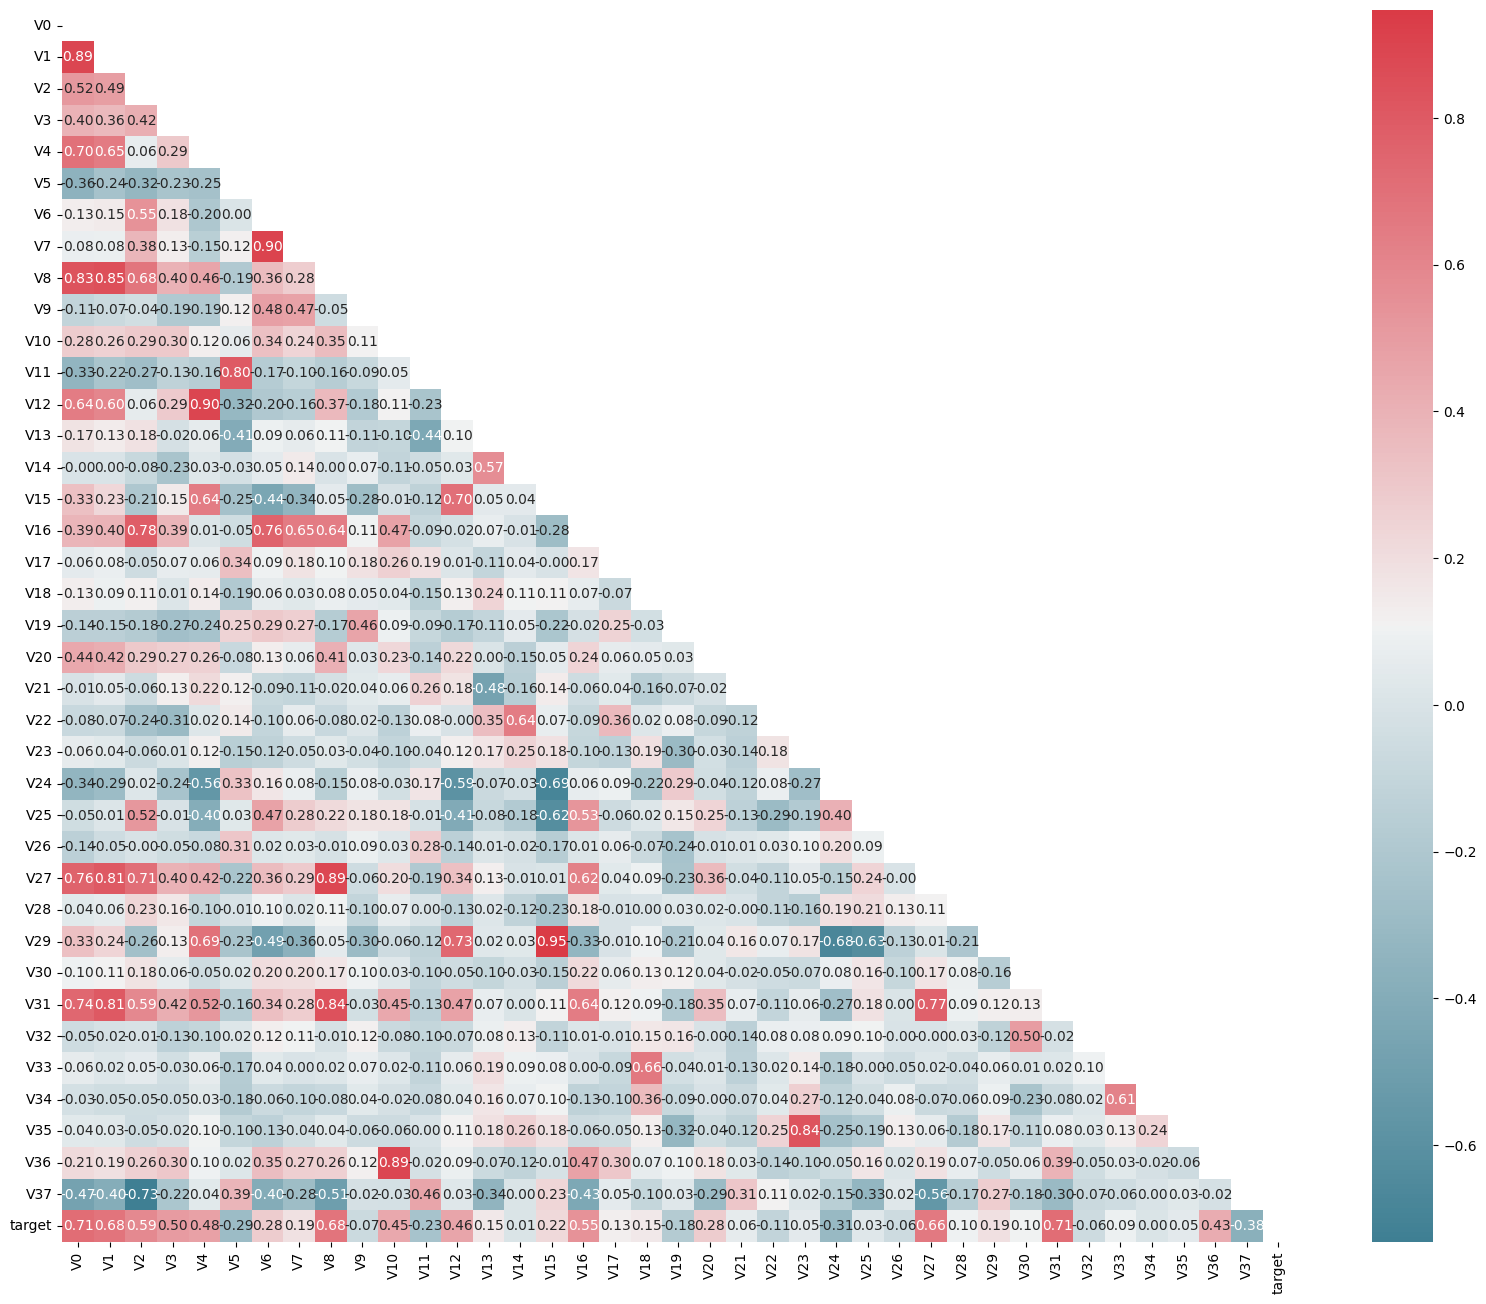

In [8]:
plt.figure(figsize=(20, 16))  
column = train_data_scaler.columns.tolist()  
mcorr = train_data_scaler[column].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True  
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

## 特征降维

### 相关新分析

In [9]:
mcorr=mcorr.abs()
numerical_corr=mcorr[mcorr['target']>0.1]['target']
print(numerical_corr.sort_values(ascending=False))

target    1.000000
V0        0.712403
V31       0.711636
V1        0.682909
V8        0.679469
V27       0.657398
V2        0.585850
V16       0.545793
V3        0.501622
V4        0.478683
V12       0.460300
V10       0.448682
V36       0.425991
V37       0.376443
V24       0.305526
V5        0.286076
V6        0.280195
V20       0.278381
V11       0.234551
V15       0.221290
V29       0.190109
V7        0.185321
V19       0.180111
V18       0.149741
V13       0.149199
V17       0.126262
V22       0.112743
V30       0.101378
Name: target, dtype: float64


### 相关性初筛

In [10]:
features_corr = numerical_corr.sort_values(ascending=False).reset_index()
features_corr.columns = ['features_and_target', 'corr']
features_corr_select = features_corr[features_corr['corr']>0.3] # 筛选出大于相关性大于0.3的特征
print(features_corr_select)
select_features = [col for col in features_corr_select['features_and_target'] if col not in ['target']]
new_train_data_corr_select = train_data_scaler[select_features+['target']]
new_test_data_corr_select = test_data_scaler[select_features]

   features_and_target      corr
0               target  1.000000
1                   V0  0.712403
2                  V31  0.711636
3                   V1  0.682909
4                   V8  0.679469
5                  V27  0.657398
6                   V2  0.585850
7                  V16  0.545793
8                   V3  0.501622
9                   V4  0.478683
10                 V12  0.460300
11                 V10  0.448682
12                 V36  0.425991
13                 V37  0.376443
14                 V24  0.305526


### 多重共线性分析

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor #多重共线性方差膨胀因子

#多重共线性
new_numerical=['V0', 'V2', 'V3', 'V4', 'V5', 'V6', 'V10','V11', 
                         'V13', 'V15', 'V16', 'V18', 'V19', 'V20', 'V22','V24','V30', 'V31', 'V37']
X=np.matrix(train_data_scaler[new_numerical])
VIF_list=[variance_inflation_factor(X, i) for i in range(X.shape[1])]
VIF_list

[216.73387180903222,
 114.38118723828812,
 27.863778129686356,
 201.96436579080174,
 78.93722825798903,
 151.06983667656212,
 14.519604941508451,
 82.69750284665385,
 28.479378440614585,
 27.759176471505945,
 526.6483470743831,
 23.50166642638334,
 19.920315849901424,
 24.640481765008683,
 11.816055964845381,
 4.958208708452915,
 37.09877416736591,
 298.26442986612767,
 47.854002539887034]

### PCA降维

In [12]:
from sklearn.decomposition import PCA   #主成分分析法
#PCA方法降维
#保留16个主成分
pca = PCA(n_components=16)
new_train_pca_16 = pca.fit_transform(train_data_scaler.iloc[:,0:-1])
new_test_pca_16 = pca.transform(test_data_scaler)
new_train_pca_16 = pd.DataFrame(new_train_pca_16)
new_test_pca_16 = pd.DataFrame(new_test_pca_16)
new_train_pca_16['target'] = train_data_scaler['target']
new_train_pca_16.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
count,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2.886000e+03,2884.000000
mean,1.138282e-16,-6.091608e-17,-1.638791e-17,-2.008288e-16,1.211205e-16,-3.455502e-17,2.810180e-17,3.524747e-17,-7.218758e-17,7.549113e-17,3.509719e-17,1.300790e-16,9.323988e-18,-3.318455e-17,-2.812344e-17,1.279963e-16,0.127274
std,3.998976e-01,3.500240e-01,2.938631e-01,2.728023e-01,2.077128e-01,1.951842e-01,1.877104e-01,1.607670e-01,1.512707e-01,1.443772e-01,1.368790e-01,1.286192e-01,1.193301e-01,1.149757e-01,1.133506e-01,1.019259e-01,0.983462
min,-1.071795e+00,-9.429479e-01,-9.948314e-01,-7.103085e-01,-7.703995e-01,-5.340298e-01,-5.993773e-01,-5.870750e-01,-6.282801e-01,-4.902376e-01,-6.341025e-01,-5.906370e-01,-4.175475e-01,-4.312585e-01,-4.170432e-01,-3.601920e-01,-3.044000
25%,-2.804085e-01,-2.613727e-01,-2.090797e-01,-1.945196e-01,-1.315613e-01,-1.264094e-01,-1.236370e-01,-1.016446e-01,-9.662211e-02,-9.296226e-02,-8.203272e-02,-7.722056e-02,-7.141586e-02,-7.477810e-02,-7.710974e-02,-6.602013e-02,-0.348500
50%,-1.417105e-02,-1.277241e-02,2.112171e-02,-2.337402e-02,-5.123002e-03,-1.355266e-02,-1.755888e-04,-4.656196e-03,2.579966e-03,-1.478169e-03,7.281289e-03,-5.734592e-03,-4.160654e-03,1.151528e-03,-1.718355e-03,-7.068528e-04,0.313000
75%,2.287306e-01,2.317720e-01,2.069571e-01,1.657590e-01,1.281658e-01,9.993179e-02,1.272104e-01,9.657235e-02,1.002686e-01,9.059255e-02,8.832308e-02,7.147968e-02,6.784975e-02,7.573900e-02,7.117894e-02,6.358842e-02,0.794250
max,1.597730e+00,1.382802e+00,1.010250e+00,1.448007e+00,1.034062e+00,1.358964e+00,6.191601e-01,7.370098e-01,6.448979e-01,5.839628e-01,6.405543e-01,6.780758e-01,5.156497e-01,4.978623e-01,4.672443e-01,4.571096e-01,2.538000


# 模型训练

## 1 导入相关库

In [13]:
from sklearn.linear_model import LinearRegression  #线性回归
from sklearn.neighbors import KNeighborsRegressor  #K近邻回归
from sklearn.tree import DecisionTreeRegressor     #决策树回归
from sklearn.ensemble import RandomForestRegressor #随机森林回归
from sklearn.svm import SVR  #支持向量回归
import lightgbm as lgb #lightGbm模型

from sklearn.model_selection import train_test_split # 切分数据
from sklearn.metrics import mean_squared_error #评价指标

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


## 2 切分数据

对训练集进行切分，得到80%的训练数据和20%的验证数据。用切分得到的训练数据训练模型，用切分得到的验证数据评估模型的性能优劣。

In [14]:
#采用 pca 保留16维特征的数据
new_train_pca_16 = new_train_pca_16.fillna(0)
train = new_train_pca_16[new_test_pca_16.columns]
target = new_train_pca_16['target']

# 切分数据 训练数据80% 验证数据20%
train_data,test_data,train_target,test_target=train_test_split(train,target,test_size=0.2,random_state=0)

## 3 多元线性回归模型

In [15]:
clf = LinearRegression()
clf.fit(train_data, train_target)
score = mean_squared_error(test_target, clf.predict(test_data))
print("LinearRegression:   ", score)

LinearRegression:    0.2716958654617835


优点：模型简单，部署方便，回归权重可以用于结果分析；训练快。

缺点：精度低，特征存在一定的共线性问题。

使用技巧：需要进行**归一化**处理，建议进行一定的特征选择，尽量避免高度相关的特征同时存在。

本题结果：效果一般，适合分析使用。

## 4 K近邻回归

In [16]:
clf = KNeighborsRegressor(n_neighbors=8) # 最近8个
clf.fit(train_data, train_target)
score = mean_squared_error(test_target, clf.predict(test_data))
print("KNeighborsRegressor:   ", score)

KNeighborsRegressor:    0.2734283133650519


优点：模型简单，易于理解，对于数据量小的情况方便快捷，可视化方便。

缺点：计算量大，不适合数据量大的情况：需要调参数。

使用技巧：特征需要**归一化**，重要的特征可以适当加一定比例的权重。

本题结果：效果一般。

## 5 随机森林回归

In [17]:
clf = RandomForestRegressor(n_estimators=200) # 200棵树模型
clf.fit(train_data, train_target)
score = mean_squared_error(test_target, clf.predict(test_data))
print("RandomForestRegressor:   ", score)

RandomForestRegressor:    0.2511567451931228


优点：使用方便，特征**无须做过多变换**；精度较高：模型并行训练快。

缺点：结果不容易解释。

使用技巧：参数调节，提高精度。

本题结果：比较适合。

## 6 LGB模型回归

In [18]:
# lgb回归模型
clf = lgb.LGBMRegressor(
        learning_rate=0.01, # 学习率
        max_depth=-1, # 树的最大深度。-1表示没有限制。
        n_estimators=5000, # 迭代次数，也就是基础模型（决策树）的数量。
        boosting_type='gbdt', # 提升类型，默认为'gbdt'，表示梯度提升决策树。
        random_state=2019, # 随机种子，用于重现结果。
        objective='regression', # 化目标，这里设置为'regression'表示回归问题。
    )

# 训练模型
clf.fit(
        X=train_data, y=train_target,
        eval_metric='MSE', # 设置评估指标eval_metric，这里使用均方误差（MSE）
        #verbose=100 # 控制训练过程中的输出信息，100表示每100轮输出一次。 # 参数已弃用,通过“callbacks”参数传递回调
        callbacks=[lgb.log_evaluation(period=100)]
    )

score = mean_squared_error(test_target, clf.predict(test_data))
print("lightGbm:   ", score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 2308, number of used features: 16
[LightGBM] [Info] Start training from score 0.119128
lightGbm:    0.25074306531775725


优点：精度高。

缺点：训练时间长，模型复杂。

使用技巧：有效的验证集防止过拟合；参数搜索。

本题结果：适用。